In [1]:
# check for requirements.txt

import os
import sys
import argparse

import torch
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms # callable
from tqdm import tqdm


In [2]:
# check if GPu is available
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [3]:
# Preprocessing & Dataset definition
data_root = os.path.join(os.getcwd(),"data")
# Composes several transforms together.
transform = transforms.Compose( 
    [
    transforms.ToTensor(), # PIL Image or ndarray-> FloatTensor with (c,h,w), Intensity to [0,1]
    transforms.Normalize([0.5],[0.5]) # normalize each channel of the input
    # mean (sequence) – Sequence of means for each channel.
    # std (sequence) – Sequence of standard deviations for each channel.
    ]
)
fashion_mnist_dataset = FashionMNIST(data_root, download=True, train=True, transform = transform)

In [4]:
data = random_split(fashion_mnist_dataset, [int(len(fashion_mnist_dataset)*0.9),int(len(fashion_mnist_dataset)*0.1)])
train_dataset = data[0]
val_dataset = data[1]

train_batchszie = 100
val_batchszie = 10

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batchszie, shuffle =True, num_workers=1
)
# Iterable object composed of iterable data

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=val_batchszie, shuffle =True, num_workers=1
)


In [5]:
def softmax(x,axis=0):
    max = np.max(x, axis=axis,keepdims=True)
    e_x = np.exp(x-max) #?
    sum = np.sum(e_x, axis=axis,keepdims=True)
    f_x = e_x/sum
    return f_x

In [21]:
class MLP(nn.Module):
    def __init__(self, input_dim: int, h1_dim: int, h2_dim: int, h3_dim: int, output_dim: int):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,h1_dim)
        self.linear2 = nn.Linear(h1_dim,h2_dim)
        self.linear3 = nn.Linear(h2_dim,h3_dim)
        self.linear4 = nn.Linear(h3_dim,h2_dim)
        self.linear5 = nn.Linear(h2_dim,output_dim)
        self.relu = F.relu
        self.softmax = F.softmax
        
    def forward(self,input):
        x = torch.flatten(input,start_dim=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.relu(self.linear4(x))
        output = self.softmax(self.linear5(x),dim=1)
        return output 

In [22]:
model = MLP(28*28, 128, 64, 32, 10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
max_epoch=15
log_interval = 100

In [23]:
train_step = 0
for epoch in range(1,max_epoch+1):
    
    # valid step
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        
        for val_batch_idx, (val_images,val_labels) in enumerate(tqdm(val_dataloader,position=0,leave=True,desc='validation')):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_images)
            _, val_preds = torch.max(val_outputs,1)
            val_loss += loss_function(val_outputs,val_labels) / val_outputs.shape[0] # per batch
            val_corrects += torch.sum(val_preds == val_labels.data) / val_outputs.shape[0] # per batch
    
    # Validation logging
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_acc = val_corrects / len(val_dataloader)
    
    print(
        f"{epoch}: epoch, {train_step} step: val_loss : {val_epoch_loss}, val_acc: {val_epoch_acc}"
    )
    
    # train step
    for batch_idx, (images,labels) in enumerate(tqdm(train_dataloader,position=0,leave=True,desc='Train')):
        current_loss = 0.0
        current_corrects = 0
        
        images = images.to(device)
        labels = labels.to(device)     
        
        #Forward
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        loss = loss_function(outputs,labels)
        
        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        current_loss += loss.item()
        current_corrects += torch.sum(preds==labels.data)
        # Train logging
        if train_step % log_interval == 0: # Performance log per batch
            train_loss = current_loss / log_interval # average loss
            train_acc = current_corrects / log_interval # average acc
            print(
                f"{train_step}: train_loss : {train_loss}, train_acc: {train_acc}"
            )
            current_loss = 0
            current_corrects = 0
            
        train_step+=1
        

validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 311.72it/s]


1: epoch, 0 step: val_loss : 0.23025000095367432, val_acc: 0.09933323413133621


Train:   2%|█▎                                                                        | 10/540 [00:01<00:41, 12.80it/s]

0: train_loss : 0.023026716709136964, train_acc: 0.08999999612569809


Train:  21%|███████████████▏                                                         | 112/540 [00:02<00:05, 80.26it/s]

100: train_loss : 0.01786495923995972, train_acc: 0.699999988079071


Train:  40%|████████████████████████████▉                                            | 214/540 [00:03<00:03, 85.01it/s]

200: train_loss : 0.017827147245407106, train_acc: 0.6899999976158142


Train:  58%|██████████████████████████████████████████▍                              | 314/540 [00:04<00:02, 83.16it/s]

300: train_loss : 0.017310906648635865, train_acc: 0.7299999594688416


Train:  77%|████████████████████████████████████████████████████████▏                | 416/540 [00:05<00:01, 84.53it/s]

400: train_loss : 0.0164434015750885, train_acc: 0.8100000023841858


Train:  96%|█████████████████████████████████████████████████████████████████████▉   | 517/540 [00:07<00:00, 84.24it/s]

500: train_loss : 0.017096242904663085, train_acc: 0.75


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 303.17it/s]


2: epoch, 540 step: val_loss : 0.16576968133449554, val_acc: 0.8069989681243896


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 72.16it/s]

600: train_loss : 0.01693652033805847, train_acc: 0.7799999713897705


Train:  32%|███████████████████████                                                  | 171/540 [00:02<00:04, 84.55it/s]

700: train_loss : 0.01686033368110657, train_acc: 0.7699999809265137


Train:  50%|████████████████████████████████████▌                                    | 270/540 [00:04<00:03, 84.97it/s]

800: train_loss : 0.016541196107864378, train_acc: 0.8100000023841858


Train:  69%|██████████████████████████████████████████████████▎                      | 372/540 [00:05<00:02, 83.17it/s]

900: train_loss : 0.016316524744033813, train_acc: 0.8299999833106995


Train:  87%|███████████████████████████████████████████████████████████████▊         | 472/540 [00:06<00:00, 83.54it/s]

1000: train_loss : 0.016543681621551513, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:02<00:00, 296.17it/s]


3: epoch, 1080 step: val_loss : 0.16332660615444183, val_acc: 0.8289984464645386


Train:   7%|█████                                                                     | 37/540 [00:01<00:10, 46.41it/s]

1100: train_loss : 0.015849723815917968, train_acc: 0.8799999952316284


Train:  26%|██████████████████▋                                                      | 138/540 [00:02<00:04, 82.67it/s]

1200: train_loss : 0.015822434425354005, train_acc: 0.8899999856948853


Train:  42%|██████████████████████████████▉                                          | 229/540 [00:03<00:03, 82.27it/s]

1300: train_loss : 0.016346098184585572, train_acc: 0.8299999833106995


Train:  61%|████████████████████████████████████████████▋                            | 331/540 [00:04<00:02, 82.35it/s]

1400: train_loss : 0.016540899276733398, train_acc: 0.7999999523162842


Train:  80%|██████████████████████████████████████████████████████████▎              | 431/540 [00:06<00:01, 82.37it/s]

1500: train_loss : 0.016186214685440063, train_acc: 0.8399999737739563


Train:  98%|███████████████████████████████████████████████████████████████████████▊ | 531/540 [00:07<00:00, 80.59it/s]

1600: train_loss : 0.01615480661392212, train_acc: 0.85999995470047


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 309.79it/s]


4: epoch, 1620 step: val_loss : 0.16219095885753632, val_acc: 0.8403316736221313


Train:  17%|████████████▎                                                             | 90/540 [00:01<00:05, 78.27it/s]

1700: train_loss : 0.016088279485702513, train_acc: 0.85999995470047


Train:  35%|█████████████████████████▌                                               | 189/540 [00:03<00:04, 82.77it/s]

1800: train_loss : 0.016800208091735838, train_acc: 0.7699999809265137


Train:  54%|███████████████████████████████████████▎                                 | 291/540 [00:04<00:02, 84.60it/s]

1900: train_loss : 0.016540310382843017, train_acc: 0.7999999523162842


Train:  72%|████████████████████████████████████████████████████▊                    | 391/540 [00:05<00:01, 82.68it/s]

2000: train_loss : 0.016699461936950682, train_acc: 0.7899999618530273


Train:  91%|██████████████████████████████████████████████████████████████████▌      | 492/540 [00:06<00:00, 82.00it/s]

2100: train_loss : 0.016494576930999757, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.63it/s]


5: epoch, 2160 step: val_loss : 0.16198566555976868, val_acc: 0.8421655297279358


Train:   9%|██████▉                                                                   | 51/540 [00:01<00:07, 62.69it/s]

2200: train_loss : 0.015794117450714112, train_acc: 0.8799999952316284


Train:  28%|████████████████████▋                                                    | 153/540 [00:02<00:04, 83.31it/s]

2300: train_loss : 0.01565131187438965, train_acc: 0.8899999856948853


Train:  47%|██████████████████████████████████▏                                      | 253/540 [00:03<00:03, 83.33it/s]

2400: train_loss : 0.016646430492401124, train_acc: 0.7899999618530273


Train:  65%|███████████████████████████████████████████████▋                         | 353/540 [00:05<00:02, 87.03it/s]

2500: train_loss : 0.01626636624336243, train_acc: 0.8399999737739563


Train:  84%|█████████████████████████████████████████████████████████████▏           | 453/540 [00:06<00:01, 80.29it/s]

2600: train_loss : 0.016593806743621826, train_acc: 0.7999999523162842


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 300.43it/s]


6: epoch, 2700 step: val_loss : 0.16112414002418518, val_acc: 0.8498309254646301


Train:   2%|█▎                                                                         | 9/540 [00:01<00:48, 11.05it/s]

2700: train_loss : 0.016358135938644408, train_acc: 0.8199999928474426


Train:  21%|███████████████▋                                                         | 116/540 [00:02<00:05, 78.01it/s]

2800: train_loss : 0.01595861792564392, train_acc: 0.8700000047683716


Train:  40%|█████████████████████████████▏                                           | 216/540 [00:03<00:03, 82.82it/s]

2900: train_loss : 0.01618736982345581, train_acc: 0.8399999737739563


Train:  59%|██████████████████████████████████████████▊                              | 317/540 [00:04<00:02, 84.93it/s]

3000: train_loss : 0.017319819927215575, train_acc: 0.7199999690055847


Train:  76%|███████████████████████████████████████████████████████▎                 | 409/540 [00:05<00:01, 82.82it/s]

3100: train_loss : 0.015772303342819215, train_acc: 0.8700000047683716


Train:  94%|████████████████████████████████████████████████████████████████████▊    | 509/540 [00:07<00:00, 83.65it/s]

3200: train_loss : 0.0162136173248291, train_acc: 0.8499999642372131


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.95it/s]


7: epoch, 3240 step: val_loss : 0.16190145909786224, val_acc: 0.841331422328949


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 70.86it/s]

3300: train_loss : 0.0162544584274292, train_acc: 0.8399999737739563


Train:  32%|███████████████████████                                                  | 171/540 [00:02<00:04, 81.44it/s]

3400: train_loss : 0.016012184619903565, train_acc: 0.8700000047683716


Train:  50%|████████████████████████████████████▋                                    | 271/540 [00:04<00:03, 82.42it/s]

3500: train_loss : 0.01626191258430481, train_acc: 0.8399999737739563


Train:  69%|██████████████████████████████████████████████████▎                      | 372/540 [00:05<00:02, 79.12it/s]

3600: train_loss : 0.01674782156944275, train_acc: 0.7799999713897705


Train:  88%|███████████████████████████████████████████████████████████████▉         | 473/540 [00:06<00:00, 82.60it/s]

3700: train_loss : 0.01633196830749512, train_acc: 0.8299999833106995


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 318.91it/s]


8: epoch, 3780 step: val_loss : 0.16032980382442474, val_acc: 0.8573309779167175


Train:   5%|███▊                                                                      | 28/540 [00:01<00:14, 36.15it/s]

3800: train_loss : 0.016434621810913087, train_acc: 0.8100000023841858


Train:  25%|██████████████████▌                                                      | 137/540 [00:02<00:04, 83.30it/s]

3900: train_loss : 0.015944814682006835, train_acc: 0.8700000047683716


Train:  42%|██████████████████████████████▉                                          | 229/540 [00:03<00:03, 78.96it/s]

4000: train_loss : 0.015546923875808716, train_acc: 0.9099999666213989


Train:  63%|█████████████████████████████████████████████▋                           | 338/540 [00:05<00:02, 85.23it/s]

4100: train_loss : 0.016259727478027345, train_acc: 0.8299999833106995


Train:  80%|██████████████████████████████████████████████████████████▏              | 430/540 [00:06<00:01, 83.80it/s]

4200: train_loss : 0.015850540399551392, train_acc: 0.8700000047683716


Train:  98%|███████████████████████████████████████████████████████████████████████▋ | 530/540 [00:07<00:00, 85.54it/s]

4300: train_loss : 0.016220648288726807, train_acc: 0.8499999642372131


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 317.34it/s]


9: epoch, 4320 step: val_loss : 0.16134659945964813, val_acc: 0.8473314046859741


Train:  18%|█████████████                                                             | 95/540 [00:02<00:05, 75.65it/s]

4400: train_loss : 0.015013306140899659, train_acc: 0.9699999690055847


Train:  35%|█████████████████████████▎                                               | 187/540 [00:03<00:04, 85.89it/s]

4500: train_loss : 0.016316959857940672, train_acc: 0.8299999833106995


Train:  54%|███████████████████████████████████████                                  | 289/540 [00:04<00:03, 83.18it/s]

4600: train_loss : 0.01640815019607544, train_acc: 0.8100000023841858


Train:  72%|████████████████████████████████████████████████████▋                    | 390/540 [00:05<00:01, 84.22it/s]

4700: train_loss : 0.01628289222717285, train_acc: 0.8299999833106995


Train:  91%|██████████████████████████████████████████████████████████████████       | 489/540 [00:06<00:00, 81.80it/s]

4800: train_loss : 0.015899583101272582, train_acc: 0.8700000047683716


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 301.99it/s]


10: epoch, 4860 step: val_loss : 0.1601492166519165, val_acc: 0.8601648211479187


Train:   9%|██████▊                                                                   | 50/540 [00:01<00:08, 57.68it/s]

4900: train_loss : 0.015496878623962403, train_acc: 0.9099999666213989


Train:  29%|████████████████████▉                                                    | 155/540 [00:02<00:04, 81.41it/s]

5000: train_loss : 0.015881145000457765, train_acc: 0.8700000047683716


Train:  47%|██████████████████████████████████▎                                      | 254/540 [00:04<00:03, 82.79it/s]

5100: train_loss : 0.016325684785842894, train_acc: 0.8299999833106995


Train:  66%|███████████████████████████████████████████████▉                         | 355/540 [00:05<00:02, 85.31it/s]

5200: train_loss : 0.015599288940429688, train_acc: 0.8899999856948853


Train:  84%|█████████████████████████████████████████████████████████████▌           | 455/540 [00:06<00:01, 82.21it/s]

5300: train_loss : 0.015863879919052123, train_acc: 0.8700000047683716


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 319.31it/s]


11: epoch, 5400 step: val_loss : 0.1611390858888626, val_acc: 0.8484976291656494


Train:   3%|██▎                                                                       | 17/540 [00:01<00:23, 22.54it/s]

5400: train_loss : 0.016201040744781493, train_acc: 0.8399999737739563


Train:  20%|██████████████▊                                                          | 110/540 [00:02<00:05, 81.01it/s]

5500: train_loss : 0.016537836790084838, train_acc: 0.7999999523162842


Train:  39%|████████████████████████████▋                                            | 212/540 [00:03<00:03, 84.10it/s]

5600: train_loss : 0.01596252918243408, train_acc: 0.8700000047683716


Train:  58%|██████████████████████████████████████████▎                              | 313/540 [00:04<00:03, 73.24it/s]

5700: train_loss : 0.01621547222137451, train_acc: 0.8399999737739563


Train:  76%|███████████████████████████████████████████████████████▋                 | 412/540 [00:05<00:01, 84.15it/s]

5800: train_loss : 0.015068877935409546, train_acc: 0.949999988079071


Train:  95%|█████████████████████████████████████████████████████████████████████▏   | 512/540 [00:07<00:00, 82.71it/s]

5900: train_loss : 0.015932402610778808, train_acc: 0.8700000047683716


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 316.28it/s]


12: epoch, 5940 step: val_loss : 0.16019022464752197, val_acc: 0.8584976196289062


Train:  13%|█████████▋                                                                | 71/540 [00:01<00:06, 69.49it/s]

6000: train_loss : 0.016482182741165162, train_acc: 0.8100000023841858


Train:  32%|███████████████████████                                                  | 171/540 [00:03<00:04, 84.54it/s]

6100: train_loss : 0.016034812927246095, train_acc: 0.8499999642372131


Train:  51%|█████████████████████████████████████                                    | 274/540 [00:04<00:03, 85.28it/s]

6200: train_loss : 0.015800813436508177, train_acc: 0.8899999856948853


Train:  69%|██████████████████████████████████████████████████▌                      | 374/540 [00:05<00:01, 83.54it/s]

6300: train_loss : 0.016014233827590943, train_acc: 0.8700000047683716


Train:  88%|████████████████████████████████████████████████████████████████▏        | 475/540 [00:06<00:00, 83.92it/s]

6400: train_loss : 0.016466174125671387, train_acc: 0.8100000023841858


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 314.04it/s]


13: epoch, 6480 step: val_loss : 0.16030682623386383, val_acc: 0.8576642274856567


Train:   6%|████▊                                                                     | 35/540 [00:01<00:11, 44.98it/s]

6500: train_loss : 0.015674861669540404, train_acc: 0.8999999761581421


Train:  25%|██████████████████                                                       | 134/540 [00:02<00:04, 81.67it/s]

6600: train_loss : 0.01580619215965271, train_acc: 0.8799999952316284


Train:  43%|███████████████████████████████▋                                         | 234/540 [00:03<00:03, 84.17it/s]

6700: train_loss : 0.016063287258148193, train_acc: 0.8700000047683716


Train:  62%|█████████████████████████████████████████████▏                           | 334/540 [00:04<00:02, 83.41it/s]

6800: train_loss : 0.01564202904701233, train_acc: 0.8899999856948853


Train:  80%|██████████████████████████████████████████████████████████▌              | 433/540 [00:06<00:01, 82.56it/s]

6900: train_loss : 0.01548690438270569, train_acc: 0.9199999570846558


Train:  99%|████████████████████████████████████████████████████████████████████████ | 533/540 [00:07<00:00, 81.71it/s]

7000: train_loss : 0.015683635473251342, train_acc: 0.8999999761581421


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 302.84it/s]


14: epoch, 7020 step: val_loss : 0.15960736572742462, val_acc: 0.8638312220573425


Train:  18%|█████████████▍                                                            | 98/540 [00:02<00:05, 80.08it/s]

7100: train_loss : 0.015674623250961302, train_acc: 0.8899999856948853


Train:  35%|█████████████████████████▊                                               | 191/540 [00:03<00:04, 84.86it/s]

7200: train_loss : 0.01588181972503662, train_acc: 0.8799999952316284


Train:  54%|███████████████████████████████████████▍                                 | 292/540 [00:04<00:02, 84.09it/s]

7300: train_loss : 0.015897419452667236, train_acc: 0.8700000047683716


Train:  73%|█████████████████████████████████████████████████████▎                   | 394/540 [00:05<00:01, 80.72it/s]

7400: train_loss : 0.015940815210342407, train_acc: 0.8700000047683716


Train:  92%|██████████████████████████████████████████████████████████████████▉      | 495/540 [00:06<00:00, 83.66it/s]

7500: train_loss : 0.01605931282043457, train_acc: 0.85999995470047


validation: 100%|███████████████████████████████████████████████████████████████████| 600/600 [00:01<00:00, 316.93it/s]


15: epoch, 7560 step: val_loss : 0.1595613807439804, val_acc: 0.8656646013259888


Train:  10%|███████▌                                                                  | 55/540 [00:01<00:07, 62.69it/s]

7600: train_loss : 0.01649641156196594, train_acc: 0.7999999523162842


Train:  29%|████████████████████▊                                                    | 154/540 [00:02<00:04, 81.14it/s]

7700: train_loss : 0.015999478101730347, train_acc: 0.85999995470047


Train:  47%|██████████████████████████████████▍                                      | 255/540 [00:03<00:03, 82.91it/s]

7800: train_loss : 0.01592914581298828, train_acc: 0.85999995470047


Train:  66%|████████████████████████████████████████████████▏                        | 356/540 [00:05<00:02, 83.09it/s]

7900: train_loss : 0.015620837211608887, train_acc: 0.8999999761581421


Train:  84%|█████████████████████████████████████████████████████████████▋           | 456/540 [00:06<00:01, 83.39it/s]

8000: train_loss : 0.015241022109985352, train_acc: 0.9399999976158142


Train: 100%|█████████████████████████████████████████████████████████████████████████| 540/540 [00:07<00:00, 72.14it/s]


In [24]:
os.makedirs("./logs/models",exist_ok=True)
torch.save(model,"./logs/models/mlp.ckpt")

In [25]:
loaded_model = torch.load("./logs/models/mlp.ckpt")
loaded_model.eval()
print(loaded_model)

MLP(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=10, bias=True)
)


In [27]:
test_batch_size=100
test_dataset = FashionMNIST(data_root, download=True, train=False,transform=transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=test_batch_size, shuffle=False,num_workers=1)

test_labels_list = []
test_preds_list = []
test_outputs_list= []
for i, (test_images,test_labels) in enumerate(tqdm(test_dataloader,position=0,leave=True,desc='Test')):
    
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)
    
    test_outputs = loaded_model(test_images)
    test_outputs = test_outputs.to(device)
    
    _, test_preds = torch.max(test_outputs,1)
    
    final_outputs = test_outputs.detach().cpu().numpy()
    test_outputs_list.extend(final_outputs)
    test_labels_list.extend(test_labels.detach().cpu().numpy())
    test_preds_list.extend(test_preds.detach().cpu().numpy())
    
test_preds_list = np.array(test_preds_list)
test_labels_list = np.array(test_labels_list)

print(f'\n acc :{np.mean(test_preds_list==test_labels_list)*100}%')

Test: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.93it/s]


 acc :56.89999999999999%


In [30]:
np.array(test_outputs_list)

array([[1.8105619e-11, 7.0733358e-07, 9.2016425e-17, ..., 1.7165143e-05,
        3.7918006e-05, 9.9964118e-01],
       [5.3190379e-13, 1.0299357e-13, 5.0163901e-01, ..., 6.0518166e-14,
        1.5931329e-05, 4.5424725e-23],
       [3.8141153e-19, 1.0000000e+00, 1.6513645e-23, ..., 7.1188371e-25,
        4.5079871e-17, 1.5600819e-19],
       ...,
       [5.0239612e-17, 5.5774349e-19, 1.6603176e-20, ..., 9.9598784e-15,
        1.0000000e+00, 1.0806952e-18],
       [7.1952835e-17, 1.0000000e+00, 2.2789092e-21, ..., 3.5860261e-18,
        2.6017007e-15, 3.5606216e-12],
       [4.0805148e-08, 1.9513898e-06, 4.1905125e-08, ..., 3.1328045e-06,
        9.9670202e-01, 6.5522397e-07]], dtype=float32)

In [35]:
np.array(test_outputs_list)[:,1]

array([7.0733358e-07, 1.0299357e-13, 1.0000000e+00, ..., 5.5774349e-19,
       1.0000000e+00, 1.9513898e-06], dtype=float32)

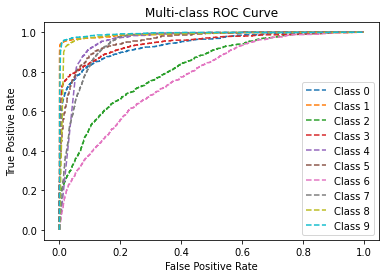

auc_score 0.9298256999999999


In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

false_positive_rate = {}
true_positive_rate = {}
threshold = {}
n_class = 10

for i in range(n_class):
    false_positive_rate[i],true_positive_rate[i],threshold[i] = roc_curve(test_labels_list, np.array(test_outputs_list)[:,i],pos_label=i)
for i in range(n_class):
    plt.plot(false_positive_rate[i],true_positive_rate[i],linestyle='--',label=f"Class {i}")
    
plt.title('Multi-class ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

print("auc_score",roc_auc_score(test_labels_list,test_outputs_list,multi_class='ovo',average='macro'))